In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from os.path import join
import skbio
import numpy as np
import seaborn as sns
from skbio.stats.distance import permanova

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##Define a function to take the intersect of a distance matrix and map

In [2]:
def filter_dm_and_map(dm, map_df):
    ids_to_exclude = set(dm.ids) - set(map_df.index.values)
    ids_to_keep = set(dm.ids) - ids_to_exclude
    filtered_dm = dm.filter(ids_to_keep)
    filtered_map = map_df.loc[ids_to_keep]

    return filtered_dm, filtered_map

##Load distance matrices

In [3]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
uw_dm = skbio.DistanceMatrix.read(join(home, 'core_div_out/bdiv_even1000/unweighted_unifrac_dm.txt'))
w_dm = skbio.DistanceMatrix.read(join(home, 'core_div_out/bdiv_even1000/weighted_unifrac_dm.txt'))

Load the mapping file
--------------------
The mapping file will be filtered to only include 16S, row 3 Flagstaff period 2 and 3 samples with no duplicates or replicates. The following is intentionally verbose to improve readability

In [4]:
city_of_interest = 'flagstaff'

In [5]:

sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['Row'] != '2']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md = sample_md[sample_md['City'] == city_of_interest]
sample_md = sample_md[(sample_md['Period'] == '2') | (sample_md['Period'] == '3')]

In [6]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [7]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md.drop(reps, inplace=True)

###Filter map and matrices

In [8]:
uw_dm, sample_md_uw = filter_dm_and_map(uw_dm, sample_md)
w_dm, sample_md_w = filter_dm_and_map(w_dm, sample_md)

Retrieve all distances between materials 
---------------------

In [9]:
ids = {}
for location in ['floor', 'ceiling', 'wall']:
    for material in ['carpet', 'drywall', 'ceiling']:
        key = '{0}_{1}'.format(location, material)
        ids[key] = sample_md_w[(sample_md_w['PlateLocation'] == location) & 
                  (sample_md_w['Material'] == material)].index
        

Weighted unifrac
-----------------

In [10]:
dist_df = pd.DataFrame(data=np.nan, index=sorted(ids.keys()), columns=sorted(ids.keys()))

for key_pairs in itertools.product(ids.keys(), repeat=2):
    dists = [w_dm[i] for i in itertools.product(ids[key_pairs[0]], ids[key_pairs[1]])]
    dists = np.array(dists)
    dists = dists[dists != 0]
    dist_df[key_pairs[0]][key_pairs[1]] = np.median(dists)
    

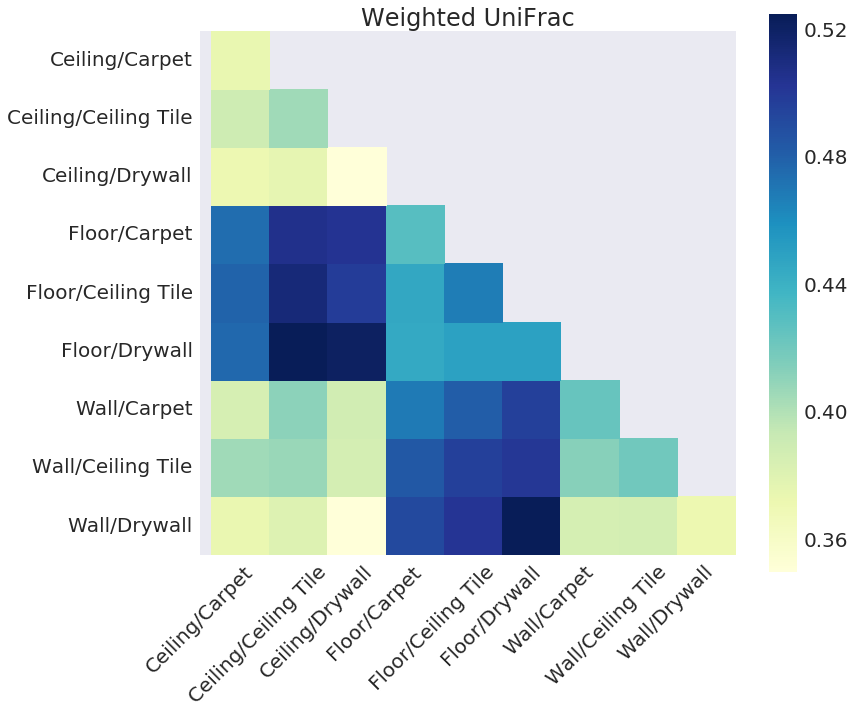

In [11]:
mask = np.zeros_like(dist_df.values)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, 0)
plt.figure(figsize=(12,10))
ticks = ['Ceiling/Carpet', 'Ceiling/Ceiling Tile', 'Ceiling/Drywall',
         'Floor/Carpet', 'Floor/Ceiling Tile', 'Floor/Drywall',
         'Wall/Carpet', 'Wall/Ceiling Tile', 'Wall/Drywall']

with plt.rc_context(dict(sns.axes_style("dark"),
                         **sns.plotting_context("notebook", font_scale=2))):



    ax = sns.heatmap(dist_df, mask=mask, square=True, cmap="YlGnBu")
    ax.set_yticklabels(ticks[::-1])
    ax.set_title('Weighted UniFrac')
plt.xticks(np.arange(9) -.2, ticks, rotation=45)
plt.savefig('figure-2-1.svg', dpi=300)

Unweighted Unifrac
------------

In [12]:
ids = {}
for location in ['floor', 'ceiling', 'wall']:
    for material in ['carpet', 'drywall', 'ceiling']:
        key = '{0}_{1}'.format(location, material)
        ids[key] = sample_md_uw[(sample_md_uw['PlateLocation'] == location) & 
                  (sample_md_uw['Material'] == material)].index
        

In [13]:
dist_df = pd.DataFrame(data=np.nan, index=sorted(ids.keys()), columns=sorted(ids.keys()))
for key_pairs in itertools.product(ids.keys(), repeat=2):
    dists = [uw_dm[i] for i in itertools.product(ids[key_pairs[0]], ids[key_pairs[1]])]
    dists = np.array(dists)
    dists = dists[dists != 0]
    dist_df[key_pairs[0]][key_pairs[1]] = np.median(dists)
    

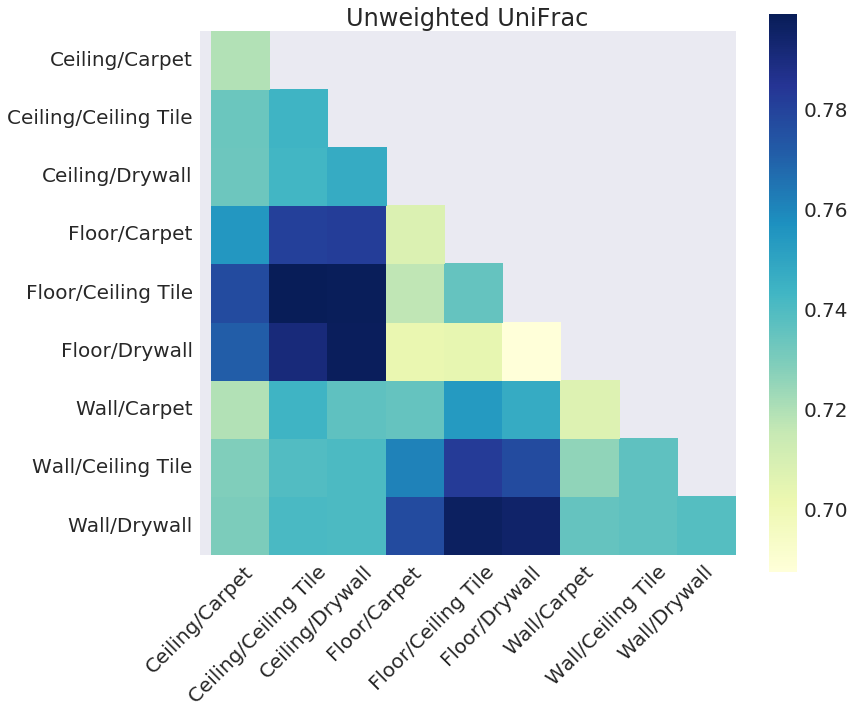

In [14]:
mask = np.zeros_like(dist_df.values)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, 0)
plt.figure(figsize=(12,10))
ticks = ['Ceiling/Carpet', 'Ceiling/Ceiling Tile', 'Ceiling/Drywall',
         'Floor/Carpet', 'Floor/Ceiling Tile', 'Floor/Drywall',
         'Wall/Carpet', 'Wall/Ceiling Tile', 'Wall/Drywall']

with plt.rc_context(dict(sns.axes_style("dark"),
                         **sns.plotting_context("notebook", font_scale=2))):



    ax = sns.heatmap(dist_df, mask=mask, square=True, cmap="YlGnBu")
    ax.set_yticklabels(ticks[::-1])
    ax.set_title('Unweighted UniFrac')
plt.xticks(np.arange(9) -.2, ticks, rotation=45)
plt.savefig('figure-2-2.svg', dpi=300)

In [15]:
permanova(w_dm, sample_md, column='PlateLocation', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     144
number of groups                  3
test statistic              11.8743
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [16]:
permanova(uw_dm, sample_md, column='PlateLocation', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     144
number of groups                  3
test statistic              5.81428
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [17]:
permanova(w_dm, sample_md, column='Material', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     144
number of groups                  3
test statistic             0.745466
p-value                        0.76
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [18]:
permanova(uw_dm, sample_md, column='Material', permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     144
number of groups                  3
test statistic              1.07638
p-value                      0.2126
number of permutations         9999
Name: PERMANOVA results, dtype: object